In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import seaborn as sns 
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [14]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')
ENSEMBLE_PATH = os.path.join(DATA_PATH, 'ensemble/malhotra')

In [15]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 378)
test_df.shape (4209, 377)


In [16]:
filter_outliers = True

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]

Filtering outliers


In [60]:
THRESHOLD = 100.0
train_df['y_class'] = train_df.y.apply(lambda x: 0 if x < THRESHOLD  else 1)
print('Class 0 ', train_df[train_df.y_class == 0].shape[0])
print('Class 1 ', train_df[train_df.y_class == 1].shape[0])

Class 0  2203
Class 1  2005


In [61]:
data = pd.concat([train_df,test_df])
data = data.drop(data.select_dtypes(include = ['object']).columns,axis=1)
data.head()

,ID,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X92,X93,X94,X95,X96,X97,X98,X99,y,y_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,130.81,1.0
1,6,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,88.53,0.0
2,7,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,76.26,0.0
3,9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,80.62,0.0
4,13,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,78.02,0.0


In [62]:
feat = list(data.drop(['y','y_class'],axis=1).columns.values)
feat.remove('ID')

In [63]:
train_df_shape_0 = train_df.shape[0]
train = (data[:train_df_shape_0])
test = (data[train_df_shape_0:])

In [64]:
from sklearn.metrics import f1_score as f1

# Calculating CV score
def cv_score(model):
    return cross_val_score(model,train[feat],train['y_class'],cv=10,scoring = 'f1').mean()

In [65]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [66]:
model = DTC(max_depth = 10, min_samples_split=100) # We don't want to overfit

In [67]:
cv_score(model)

0.85863079804965958

In [68]:
model.fit(train[feat], train.y_class)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

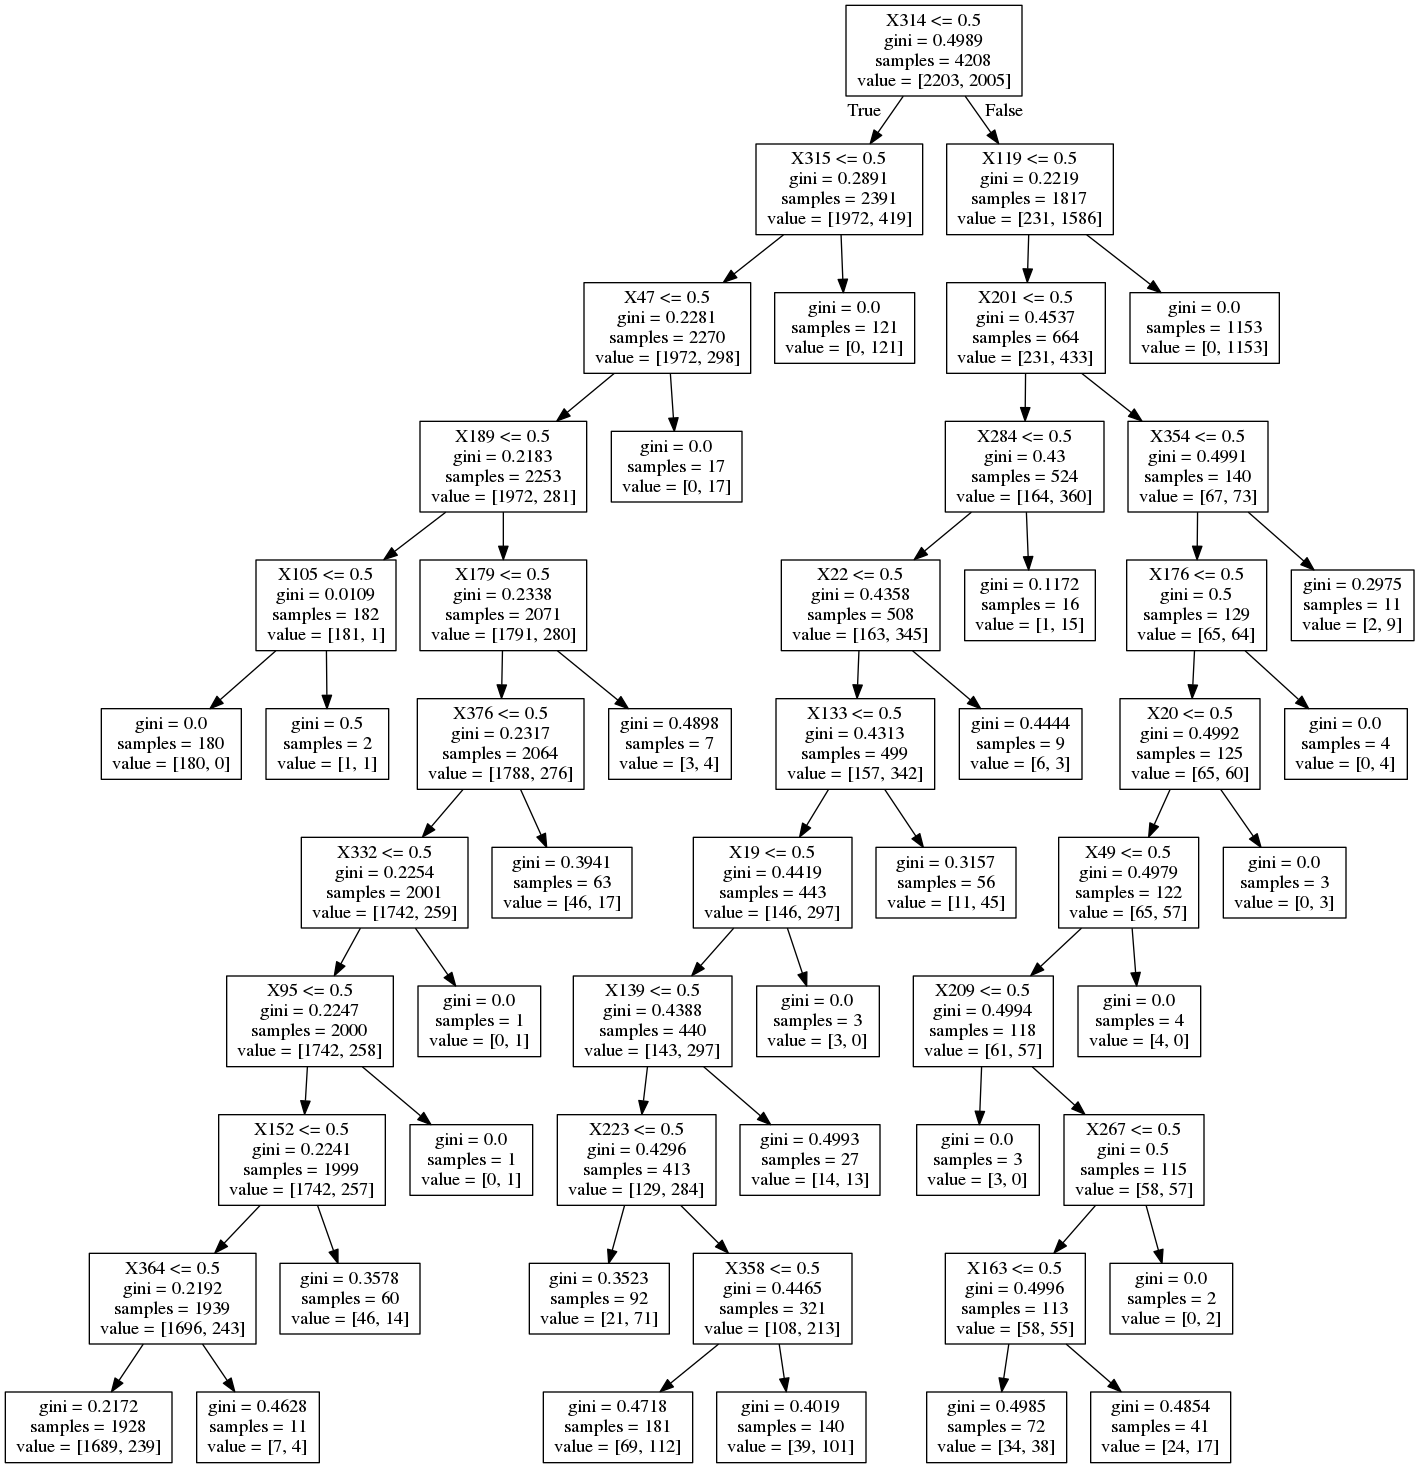

In [69]:
# Graphviz is used to build decision trees
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot

dotfile = StringIO()
tree.export_graphviz(model, out_file=dotfile, feature_names=feat)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
Image(graph[0].create_png())